In [1]:
import numpy as np
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import math
import fceulib
import networkx as nx
import nxpd
import sets
from unionfind import *

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: the sets module is deprecated


In [2]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

In [16]:

input1,input2 = pickle.load(open('inputs.pkl'))

tile_collisions = pickle.load(open('tile_collisions.pkl'))
sprite_collisions = pickle.load(open('sprite_collisions.pkl'))

merged_trace, modes = pickle.load(open("merged_trace.pkl"))


In [62]:
start_time = 0
transitions = {}

    
# Edges into [outer] from [inner]
entries_from = {m: {m: [] for m in list(modes)+[-1]} 
                for m in modes}
# Edges into [outer]
entries = {m: [] for m in modes}

prev = -1
active = []
last_time = 0
for segment in merged_trace:
    
    mode = segment
    
    start,end, mode ,_ = mode
    last_time = end
    for t in range(start,end):
        active.append(mode)
    entries_from[mode][prev].append(start)
    entries[mode].append(start)
    transitions[start] = (prev,mode)
    prev = mode
    
print entries_from
print entries
print transitions
print modes

all_tracks = pickle.load(open('all_tracks.pkl'))
for track in all_tracks:
    if track[0] == 'track1':
        break
        
    
track =  track[1]

track = [track[t][0] for t in sorted(track)]
track = np.array(track)

velocities = track[1:,1]-track[:-1,1]
y_velocities = track[1:,1]-track[:-1,1]
x_velocities = track[1:,0]-track[:-1,0]

{0: {0: [], 1: [], 2: [305, 440], 3: [], 4: [], 5: [], 6: [], -1: [0]}, 1: {0: [9, 453], 1: [], 2: [251, 501, 867], 3: [], 4: [95, 367, 658, 730, 821, 925], 5: [387, 528, 766], 6: [708], -1: []}, 2: {0: [], 1: [30, 221, 299, 410, 466, 584, 837], 2: [], 3: [], 4: [], 5: [], 6: [], -1: []}, 3: {0: [332], 1: [], 2: [64], 3: [], 4: [], 5: [794], 6: [], -1: []}, 4: {0: [], 1: [713], 2: [], 3: [77, 348, 808], 4: [], 5: [634, 896], 6: [], -1: []}, 5: {0: [], 1: [376, 517, 755, 780, 882], 2: [613], 3: [], 4: [], 5: [], 6: [], -1: []}, 6: {0: [], 1: [686], 2: [], 3: [], 4: [], 5: [], 6: [], -1: []}}
{0: [0, 305, 440], 1: [9, 95, 251, 367, 387, 453, 501, 528, 658, 708, 730, 766, 821, 867, 925], 2: [30, 221, 299, 410, 466, 584, 837], 3: [64, 332, 794], 4: [77, 348, 634, 713, 808, 896], 5: [376, 517, 613, 755, 780, 882], 6: [686]}
{0: (-1, 0), 896: (5, 4), 387: (5, 1), 517: (1, 5), 9: (0, 1), 780: (1, 5), 528: (5, 1), 658: (4, 1), 410: (1, 2), 794: (5, 3), 30: (1, 2), 837: (1, 2), 808: (3, 4), 299

{0: 3, 1: 15, 2: 7, 3: 3, 4: 6, 5: 6, 6: 1}
0 {'type': 'cN', 'N': -2.1632653061224487}
1 {'type': 'c0'}
2 {'acc': -0.25221294217505846, 'type': 'accN', 'N': 4.6488541203531888}
3 {'acc': 0.28608342561830929, 'type': 'acc0'}
4 {'acc': -0.24986171036619104, 'type': 'acc0'}
5 {'acc': 0.29569742468384413, 'type': 'accN', 'N': -2.0817495798646481}
6 {'type': 'cN', 'N': 3.2727272727272716}
-1 0 : 0 : 1
0 1 : 9 453 : 2
0 3 : 332 : 1
1 2 : 30 221 299 410 466 584 837 : 7
1 4 : 713 : 1
1 5 : 376 517 755 780 882 : 5
1 6 : 686 : 1
2 0 : 305 440 : 2
2 1 : 251 501 867 : 3
2 3 : 64 : 1
2 5 : 613 : 1
3 4 : 77 348 808 : 3
4 1 : 95 367 658 730 821 925 : 6
5 1 : 387 528 766 : 3
5 3 : 794 : 1
5 4 : 634 896 : 2
6 1 : 708 : 1


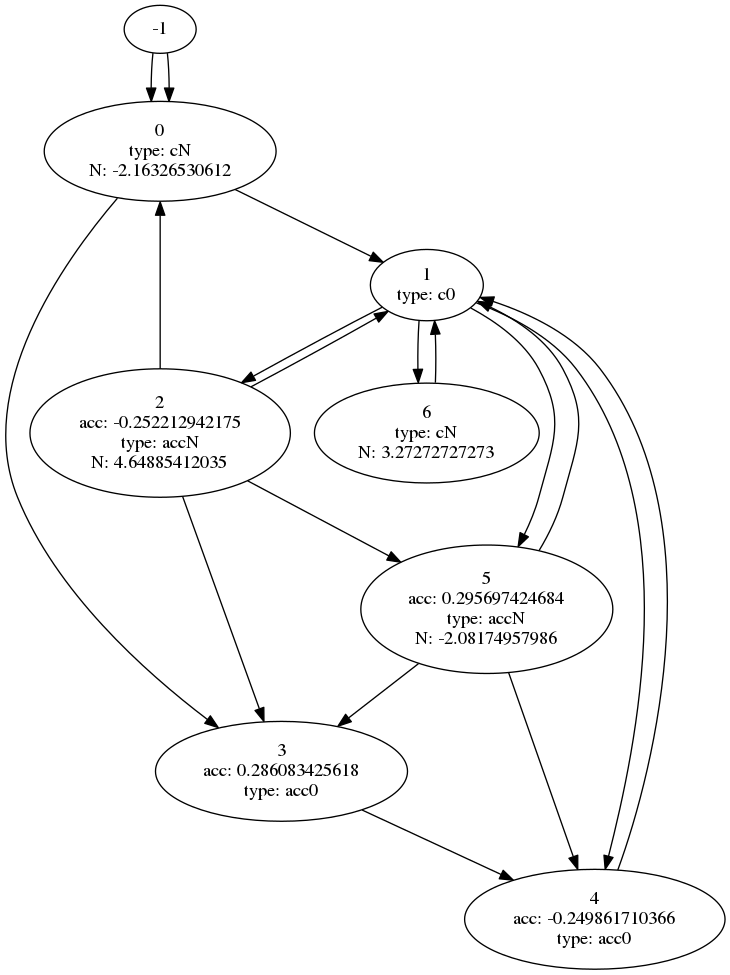

In [63]:
G = nx.MultiDiGraph()
to_add = {}

counts = {}
for tgt,srcs in entries_from.items():
    if tgt not in counts:
        counts[tgt] = 0
        
    for src,times in srcs.items():
        counts[tgt] += len(times)
print counts
for tgt,srcs in entries_from.items():
    if counts[tgt] > 0:
        G.add_node(tgt,label=str(tgt))
        # Let's learn about tgt
        mparams, mtype = modes[tgt]
        
        
        params = {"type": mtype}
        if mtype == 'c0':
            pass
        elif mtype == 'cP':
            pass
        elif mtype == 'cN':
            params["N"] = mparams[0]
        elif mtype == 'acc0':
            params["acc"] = mparams[0]
        elif mtype == 'accP':
            params["acc"] = mparams[0]
        elif mtype == 'accN':
            params["N"] = mparams[0]
            params["acc"] = mparams[1]
        for k,v in params.items():
            G.node[tgt]["label"] = (G.node[tgt]["label"] + "\n" + "{}: {}".format(k,v))
        print tgt,params
        for src,times in srcs.items():
            for t in times:
                if (src,tgt) not in to_add:
                    to_add[(src,tgt)] = []
                to_add[(src,tgt)].append('{}'.format(t))
                #G.add_edge(src,tgt,label=str(t))
for e in sorted(to_add):
    print e[0],e[1],':',' '.join(to_add[e]),':',len(to_add[e])
    G.add_edge(e[0],e[1])

G.add_node(-1)
G.add_edge(-1, 0)



nxpd.draw(G, show='ipynb')

In [64]:

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        b_ = int(b)
        buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if b_ & (1 << (7-ii)):
                buttons.append(c)
        l_ = int(last_mask)
        last_buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if l_ & (1 << (7-ii)):
                last_buttons.append(c)
        mask_times[t] = (tuple(last_buttons),tuple(buttons))
        last_mask = b
    
    return mask_times


button_change_times1 = button_changes(input1)
button_change_times2 = button_changes(input2)

In [65]:
def sign(num):
    if num < 0:
        return -1
    if num > 0:
        return 1
    return 0

def button_preds(button_pairs,input_id):
    here_i = set()
    for i,bp in button_pairs.items():
        bp0 = set(bp[0])
        bp1 = set(bp[1])
        released_i = bp0 - bp1
        pressed_i = bp1 - bp0
        held_i = bp1
        for ri in released_i:
            here_i.add(("release",ri,input_id))
        for ri in pressed_i:
            here_i.add(("press",ri,input_id))
        for ri in held_i:
            here_i.add(("hold",ri,input_id))
    return list(here_i)

def collision_preds(coll_pairs):
    here_i = set()
    for i,bp in coll_pairs.items():
        bp0 = set(bp[0])
        bp1 = set(bp[1])
        released_i = bp0 - bp1
        pressed_i = bp1 - bp0
        
        
        held_i = bp[1]
        for ri in released_i:
            here_i.add(("col_stop",ri))
        for ri in pressed_i:
            here_i.add(("col_start",ri))
        #for ri in held_i:
        #    here_i.add(("col",ri))
    return list(here_i)

In [66]:
base_preds = [set()]*last_time
first_tc_time = sorted(tile_collisions)[0]
last_tc_time = sorted(tile_collisions)[-1]
for t in range(0,last_time):
    
    # TODO: button lag variables
    psi = ({i: button_change_times1.get(start_time+t+i,((),()))
            for i in range(-5, 1)},
            {i: button_change_times2.get(start_time+t+i,((),()))
            for i in range(-5, 1)},
           # TODO: collision lag variables?
            {i:(tile_collisions.get(start_time+t+(i-1),tile_collisions[first_tc_time]),
                 tile_collisions.get(start_time+t+(i),tile_collisions[last_tc_time]))
             for i in range(-7, 1)},
            {i:(sprite_collisions.get(start_time+t+(i-1),set()),
                 sprite_collisions.get(start_time+t+(i),set()))
             for i in range(-5, 1)},
            (velocities[t-1],velocities[t-0])
          )
    buttons1_i = psi[0]
    buttons2_i = psi[1]
    t_collisions_i = psi[2]
    s_collisions_i = psi[3]
    
    
    print t
    for c in collision_preds(t_collisions_i):
        print c
    here_i = button_preds(buttons1_i,1) + button_preds(buttons2_i,2) +collision_preds(t_collisions_i) +collision_preds(s_collisions_i)
   
    vel0,vel1 = psi[4]
    if vel1 == 0:
        here_i.append(("vel",0))
    #cur_mode = X
    # TODO: touched global min/max of velocity for current mode
    #mode_max = max(velocities_in_cur_mode)
    #mode_min = min(velocities_in_cur_mode)
    #if vel1 == mode_max and vel0 != mode_max:
    #  touched max
    #if vel1 == mode_min and vel0 != mode_min:
    #  touched min
    #if vel1 == mode_max:
    #  in min
    #if vel1 == mode_min:
    #  in max
    base_preds[t] = set(here_i)

for t,p in enumerate(base_preds):
    print t,p

0
('col_start', (('tile', ('tile', 59)), ('sprite', 3)))
('col_stop', (('tile', ('tile', 41)), ('sprite', 3)))
('col_start', (('tile', ('tile', 20)), ('sprite', 3)))
('col_start', (('tilegroup', (15, 396)), 'track1'))
('col_start', (('tilegroup', (20, 270)), 'track1'))
('col_start', (('tile', ('tile', 18)), ('sprite', 3)))
('col_start', (('tilegroup', (16, 109)), 'track1'))
('col_stop', (('tile', ('tile', 67)), ('sprite', 3)))
('col_start', (('tilegroup', (17, 370)), 'track1'))
('col_start', (('tile', ('tile', 0)), ('sprite', 3)))
('col_stop', (('tilegroup', (21, 133)), 'track1'))
('col_stop', (('tilegroup', (20, 323)), 'track1'))
('col_stop', (('tile', ('tile', 49)), ('sprite', 3)))
('col_stop', (('tilegroup', (21, 292)), 'track1'))
1
('col_start', (('tile', ('tile', 59)), ('sprite', 3)))
('col_stop', (('tile', ('tile', 41)), ('sprite', 3)))
('col_start', (('tile', ('tile', 20)), ('sprite', 3)))
('col_start', (('tilegroup', (15, 396)), 'track1'))
('col_start', (('tilegroup', (20, 270)

In [68]:
def intervals_any_contains(intervals, t):
    if intervals is None:
        return True
    for (s,e) in intervals:
        if s <= t <= e:
            return True
    return False

def intervals_summed_length(intervals):
    return sum([(e-s)+1 for (s,e) in intervals])

def count_events(preds,intervals):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        if not intervals_any_contains(intervals, t): continue
        counts_by_time[t] = {}
        for p in ps:
            if p[0] in ["press","release","hold"] or "col" in p[0]:
                all_counts[p] = all_counts.get(p,0)+1./7.
                counts_by_time[t][p] = counts_by_time[t].get(p,0)+1./7.
            else:
                all_counts[p] = all_counts.get(p,0)+1
                counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
        if t in transitions:
            tr = transitions[t]
            key = ("tr",tr)
            all_counts[key] = all_counts.get(key,0)+1
            counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
            (_,dest) = tr
            keystar = ("tr",("*",dest))
            all_counts[keystar] = all_counts.get(keystar,0)+1
            counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts, counts_by_time

def count_coevents(preds,intervals):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        if not intervals_any_contains(intervals, t): continue
        counts_by_time[t] = {}
        for p1 in ps:
            for p2 in ps:
                p = (p1,p2)
                
                if p1[0] in ["press","release","hold"] or p2[0] in ["press","release","hold"] :
                    all_counts[p] = all_counts.get(p,0)+1./7.
                    counts_by_time[t][p] = counts_by_time[t].get(p,0)+1./7.
                else:
                    all_counts[p] = all_counts.get(p,0)+1
                    counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
                #all_counts[p] = all_counts.get(p,0)+1
                #counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
        if t in transitions:
            for p1 in ps:
                tr = transitions[t]
                key = (("tr",tr),p1)
                if p1[0] in ["press","release","hold"] or "col" in p1[0]:
                    all_counts[key] = all_counts.get(key,0)+1./7.
                    counts_by_time[t][key] = counts_by_time[t].get(key,0)+1./7.
                    (_,dest) = tr
                    keystar = (("tr",("*",dest)),p1)
                    all_counts[keystar] = all_counts.get(keystar,0)+1./7.
                    counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+2./3.
                else:
                    all_counts[key] = all_counts.get(key,0)+1
                    counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
                    (_,dest) = tr
                    keystar = (("tr",("*",dest)),p1)
                    all_counts[keystar] = all_counts.get(keystar,0)+1
                    counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts, counts_by_time

In [69]:
all_counts, counts_by_time = count_events(base_preds,None)
all_cocounts, cocounts_by_time = count_coevents(base_preds,None)

In [70]:
# Let's figure out which tiles block movement on which sides!
# co-occurrence of (col, BLAH) and acc0 for each BLAH.
# cluster together tiles which block on a given side (for now, all those with co-occurrence over threshold)
# then add new preds!

def cond_prob(e1s, e2, all_counts, counts_by_time):
    p2 = all_counts[e2]/float(len(counts_by_time))
    count12 = 0
    for t,cs in counts_by_time.items():
        any_e1_present = False
        for e1 in e1s:
            if e1 in cs:
                any_e1_present = True
                break
        if any_e1_present and (e2 in cs):
            count12 += 1
    p12 = count12 / float(len(counts_by_time))
    return p12 / p2

block_chance = {}
for thing,count in all_counts.items():
    # TODO: note "colliding on right with something" -> "vely=0" is not that sensible.
    #  need a notion of acc,vel,zin,zout and _other axis_ acc,vel,zin,zout.
    if thing[0] != "col" or thing[-1] != 0:
        continue
    block_chance[thing[1]] = cond_prob([("vel",0),("acc",0)], 
                                        ("col", thing[1], 0),
                                        all_counts,
                                        counts_by_time)

block_chance_unify_threshold = 0.8

merged_by_side = {}
for side in ["bottom","right","left","top"]:
    # Let's pretend colliding with sprites is the same as colliding with tiles?  Maybe needed for moving platforms?
    blockings = filter(lambda (col,prob):(col[1] == side and 
                                          prob > block_chance_unify_threshold),
                       block_chance.items())
    merged_by_side[side] = set()
    for bcol,bprob in blockings:
        merged_by_side[side].add(bcol)
    merged_by_side[side] = sets.ImmutableSet(merged_by_side[side])
        
    
#color_tiles = pickle.load(open('tile2colorized.pkl'))
for side,bcols in merged_by_side.items():
    print "----\n{}\n----".format(side)
    for bc in bcols:
        print block_chance[bc],bc[0]

----
top
----
----
right
----
----
left
----
----
bottom
----


In [71]:
# Let's add new preds now!
extended_preds = [set() for i in range(0,len(base_preds))]
for t,pset in enumerate(base_preds):
    for side,equiv in merged_by_side.items():
        for pred in pset:
            extended_preds[t].add(pred)
            if pred[0] == "col" and pred[1] in equiv:
                extended_preds[t].add(("col", (("solid", equiv), side), pred[2]))
            if pred[0] == "col_start" and pred[1] in equiv:
                extended_preds[t].add(("col_start", (("solid", equiv), side), pred[2]))
            if pred[0] == "col_stop" and pred[1] in equiv:
                extended_preds[t].add(("col_stop", (("solid", equiv), side), pred[2]))

# HACK: Drop distinctions between lag variables for now.  They were important before!
for t,pset in enumerate(extended_preds):
    extended_preds[t] = set(map(lambda p:(p[0], p[1], 0) if (p[0] == "col" or p[0] == "col_start" or 
                                                             p[0] == "col_stop" or p[0] == "press" or 
                                                             p[0] == "release" or p[0] == "hold") else p,
                                pset))

all_counts,counts_by_time = count_events(extended_preds,None)
all_cocounts,cocounts_by_time = count_coevents(extended_preds,None)


In [72]:
#TODO: update to support intervals?

def count_conditional_events(preds,condition):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        counts_by_time[t] = {}
        if condition in ps:
            for p in ps:
                all_counts[p] = all_counts.get(p,0)+1
                counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
            if t in transitions:
                tr = transitions[t]
                key = ("tr",tr)
                all_counts[key] = all_counts.get(key,0)+1
                counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
                (_,dest) = tr
                keystar = ("tr",("*",dest))
                all_counts[keystar] = all_counts.get(keystar,0)+1
                counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts

def count_joint_events(preds,conditions):
    count = 0
    for t,ps in enumerate(preds):
        trans = transitions.get(t,-1)
        is_good = True
        for condition in conditions:
            if condition not in ps and condition != trans:
                is_good = False
                break
        if is_good:
            count += 1
    return count
    
def count_conditional_coevents(preds,condition):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        counts_by_time[t] = {}
        if condition in ps:
            for p1 in ps:
                for p2 in ps:
                    p = (p1,p2)
                    all_counts[p] = all_counts.get(p,0)+1
                    counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
            if t in transitions:
                for p1 in ps:
                    tr = transitions[t]
                    key = (("tr",tr),p1)
                    all_counts[key] = all_counts.get(key,0)+1
                    counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
                    (_,dest) = tr
                    keystar = (("tr",("*",dest)),p1)
                    all_counts[keystar] = all_counts.get(keystar,0)+1
                    counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts

In [73]:
mode_periods = {}

for t in range(0,len(merged_trace)):
    cur = merged_trace[t][2]
    start = merged_trace[t][0]
    end = merged_trace[t][1]
    if cur not in mode_periods:
        mode_periods[cur] = []
    mode_periods[cur].append((start,end))

transition_leadin_intervals = {}

for src in modes:
    for tgt in modes:
        if src == tgt: continue
        intervals = [(s,e)
                      for (s,e) in mode_periods[src] 
                      if e in transitions and transitions[e][1] == tgt]
        transition_leadin_intervals[(src,tgt)] = intervals

In [77]:
inv_len = 1.0/float(len(track))
npmis = {}
pmis = {}
id2image = pickle.load(open('id2image.pkl'))
for m1 in modes:
    for m2 in modes:
        if m1 == m2: continue
        transition = (m1,m2)
        intervals = transition_leadin_intervals[transition]
        intvl_len = intervals_summed_length(intervals)
        if intvl_len == 0: continue
        tr_counts,_by_time = count_events(extended_preds, intervals)
        tr_cocounts,_by_time = count_coevents(extended_preds, intervals)
        tr_inv_len = 1.0/float(intvl_len)
        for pred in tr_counts:
            if pred != transition:
                p1 = tr_counts[pred]*tr_inv_len
                p2 = tr_counts[("tr",transition)]*tr_inv_len
                cooccur = (("tr",transition),pred)
                
                if cooccur in tr_cocounts:
                    p12 = tr_cocounts[cooccur]*tr_inv_len
                else:
                    p12 = 0.0
                if transition not in npmis:
                    npmis[transition] = {}
                if p12/(p1*p2) != 0.0:
                    pmi = np.log(p12/(p1*p2))
                    npmi = pmi/-np.log(p12)
                        
                    pmis[(transition,pred)] = pmi
                    npmis[transition][pred] = npmi
                else:
                    npmis[transition][pred] = -1.0
for t in sorted(npmis):
    explanations = {'input':[],
                    'collision':[]}
    for e1,pmi in reversed(sorted(npmis[t].items(), lambda a,b:sign(b[1] - a[1]))):
        if pmi > 0.25:
            if e1[0] in ['col_start','col_end']:
                explanations['collision'].append((pmi,e1))
            elif e1[0] in ['press','hold','release']:
                explanations['input'].append((pmi,e1))
                
                
    for i in sorted(explanations['input'],reverse=True):
        print t,i
    for i in sorted(explanations['collision'],reverse=True):
        print t,i
            
    print ''

(0, 1) (0.48495786851284517, ('col_start', (('tile', ('tile', 72)), ('sprite', 4)), 0))
(0, 1) (0.48495786851284517, ('col_start', (('tile', ('tile', 67)), ('sprite', 4)), 0))
(0, 1) (0.48495786851284517, ('col_start', (('tile', ('tile', 49)), ('sprite', 4)), 0))
(0, 1) (0.48495786851284517, ('col_start', (('tile', ('tile', 41)), ('sprite', 4)), 0))
(0, 1) (0.48495786851284517, ('col_start', (('tile', ('tile', 21)), ('sprite', 4)), 0))


(1, 2) (0.53995919640463119, ('press', 'A', 0))
(1, 2) (0.30144117821135019, ('hold', 'A', 0))
(1, 2) (0.26018968388239005, ('col_start', (('tilegroup', (7, 259)), 'track1'), 0))
(1, 2) (0.26018968388239005, ('col_start', (('tile', ('tile', 3)), ('sprite', 6)), 0))


(1, 5) (0.27016471174272572, ('col_start', (('tile', ('tile', 44)), ('sprite', 3)), 0))
(1, 5) (0.27016471174272572, ('col_start', (('tile', ('tile', 18)), ('sprite', 3)), 0))

(1, 6) (0.50330227361311508, ('press', 'A', 0))

(2, 0) (0.52734681216417023, ('release', 'R', 0))
(2, 0) (0.4032

In [75]:
edges = {}
for t in sorted(npmis):
    for e1,pmi in reversed(sorted(npmis[t].items(), lambda a,b:sign(b[1] - a[1]))):
        if pmi > 0.4:
            from_mode = t[0]
            to_mode = t[1]
            if from_mode not in edges:
                edges[from_mode] = {}
            if e1 not in edges[from_mode]:
                edges[from_mode][e1] = []
            edges[from_mode][e1].append(to_mode)   
for from_mode in edges:
    print from_mode
    for cause in edges[from_mode]:
        print '\t',cause , '->'
        for to_mode in edges[from_mode][cause]:
            print '\t\t',to_mode
            if len(edges[from_mode][cause]) > 1:
                print '\t\t',entries_from[to_mode][from_mode]
                for time in entries_from[to_mode][from_mode]:
                    print np.abs(filtered_x[time]), y_velocities[time]

0
	('col_start', (('tile', ('tile', 41)), ('sprite', 4)), 0) ->
		1
	('vel', 0) ->
		1
	('col_start', (('tile', ('tile', 67)), ('sprite', 4)), 0) ->
		1
	('col_stop', (('tile', ('tile', 72)), ('sprite', 3)), 0) ->
		1
	('col_stop', (('tile', ('tile', 21)), ('sprite', 3)), 0) ->
		1
	('col_start', (('tile', ('tile', 49)), ('sprite', 4)), 0) ->
		1
	('col_start', (('tile', ('tile', 72)), ('sprite', 4)), 0) ->
		1
	('col_start', (('tile', ('tile', 21)), ('sprite', 4)), 0) ->
		1
1
	('col_stop', (('tile', ('tile', 3)), ('sprite', 6)), 0) ->
		2
	('col_stop', (('tilegroup', (7, 259)), 'track1'), 0) ->
		2
	('press', 'A', 0) ->
		2
		[30, 221, 299, 410, 466, 584, 837]


NameError: name 'filtered_x' is not defined

In [ ]:
from sklearn import tree
import graphviz 
X = [[1.6],
     [2.],
     [2.5],
     [1.7],
     [2.5],
     [1.],
     [0.],
     [0.],
     [0.5],
     [0.],
     [0.],
     [2.1]]
Y = [[0],
     [0],
     [0],
     [0],
     [0],
     [1],
     [2],
     [2],
     [2],
     [2],
     [2],
     [2]]



def get_likelihood(classifier,X,Y):
    pY = clf.predict_proba(X)
    summed = 0
    for y,p in zip(Y,pY):
        summed += -np.log(p[y])
    return summed
        
def get_structure(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    count = 0
    for i in range(n_nodes):
        if not is_leaves[i]:
            count += 1
    return count
best_value = float('inf')
best_graph = None


for d in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=d,splitter='best')
    clf = clf.fit(X, Y)


    score = get_likelihood(clf,X,Y)+(1+np.log(len(Y))*0.5)*get_structure(clf)
    print score
    if score < best_value:
        best_value = score
        best_graph = tree.export_graphviz(clf, out_file=None,  
                             class_names=["0","1","2"]  ) 

graph = graphviz.Source(best_graph) 

graph


In [ ]:

X = np.hstack((x_velocities[348:355].reshape(-1,1),np.abs(x_velocities[348:355]).reshape(-1,1),np.linspace(0,355-348-1,355-348).reshape(-1,1)))
Y = [0,0,0,0,0,0,1]

X = np.hstack((x_velocities[348:355].reshape(-1,1),np.abs(x_velocities[348:355]).reshape(-1,1),np.linspace(0,355-348-1,355-348).reshape(-1,1)))
Y = [0,0,0,0,0,0,1]


for d in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=d,splitter='best')
    clf = clf.fit(X, Y)


    score = get_likelihood(clf,X,Y)+(1+np.log(len(Y))*0.5)*get_structure(clf)
    print score
    if score < best_value:
        best_value = score
        best_graph = tree.export_graphviz(clf, out_file=None,  
                             class_names=["0","1","2"]  ) 

graph = graphviz.Source(best_graph) 

graph

In [ ]:
print len(base_preds)
for d in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=d,splitter='best')
    clf = clf.fit(X, Y)


    score = get_likelihood(clf,X,Y)+(1+np.log(len(Y))*0.5)*get_structure(clf)
    print score
    if score < best_value:
        best_value = score
        best_graph = tree.export_graphviz(clf, out_file=None,  
                             class_names=["0","1","2"]  ) 

graph = graphviz.Source(best_graph) 

graph

In [ ]:
print last_time